# Digital Image Processing<br> Problem 10<br> Felix Neutatz

##Image representation and description 

In [390]:
%matplotlib inline

In [483]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial
from random import randint

In [484]:
def plotGreyImage(imageToPlot, title):
    plt.imshow(imageToPlot, cmap='gray') #Greys_r
    plt.title(title)
    plt.axis('off')
    plt.show()

### (a). Develop a program to implement the boundary following algorithm, the resampling grid and calculate the chain code and the first difference chain code.

In [485]:
def zero_padding(img, pixels):
    padding = np.zeros((img.shape[0] + pixels*2, img.shape[1] + pixels*2))
    
    padding[pixels:(img.shape[0]+pixels),pixels:(img.shape[1]+pixels)] = img
    
    return padding

In [486]:
def crop_image(img, pixels):
    return(img[ pixels:(img.shape[0]-pixels),pixels:(img.shape[1]-pixels) ])

In [510]:
neighbor = {}
#               y  x
neighbor[0] = [ 0,+1]
neighbor[1] = [-1,+1]
neighbor[2] = [-1, 0]
neighbor[3] = [-1,-1]
neighbor[4] = [ 0,-1]
neighbor[5] = [+1,-1]
neighbor[6] = [+1, 0]
neighbor[7] = [+1,+1]

dist = {}
#      y  x
dist[( 0,+1)] = 0
dist[(-1,+1)] = 1
dist[(-1, 0)] = 2
dist[(-1,-1)] = 3
dist[( 0,-1)] = 4
dist[(+1,-1)] = 5
dist[(+1, 0)] = 6
dist[(+1,+1)] = 7


translate = {}
translate[0] = 2
translate[1] = 4
translate[2] = 4
translate[3] = 6
translate[4] = 6
translate[5] = 0
translate[6] = 0
translate[7] = 2


In [517]:
def boundary_following(pic):
    
    img_pat = np.copy(pic)    
    
    b0 = [-1,-1]
    found = False
    #Let the starting point, b0, be the uppermost, leftmost point in the image that is labeled 1.
    #be careful y = first dimension and x = second dimension!!!
    for y in range(img_pat.shape[0]):
        for x in range(img_pat.shape[1]):
            if (img_pat[y,x] == 1):
                b0 = np.array([y,x])
                found = True
                break
        if (found):
            break
                
    sequence = [b0]
    
    #Denote by c0 the west neighbor of b0
    c0_code = 4    
    
    while (True):  
    #for _ in range(100):
        for n in np.arange(1,8,1):
            #get next clockwise neighbor
            b1_code = (c0_code - n) % 8
            b1 = (b0 + neighbor[b1_code])

            if (img_pat[b1[0], b1[1]] == 1): 
                sequence.append(b1)
                b0 = b1
                c0_code = translate[b1_code]
                break
        
        if (np.array_equal(sequence[-1], sequence[0])): #while the point we found is not the first point in the sequence
            break
    
    return sequence

In [489]:
def resampling_grid(sequence, grid_unit):
    end = 0
    i = 0
    resampled_sequence = []
    for point in sequence:
        p_sample = np.array([round(point[1] / float(grid_unit[1])) * grid_unit[1], round(point[0] / float(grid_unit[0])) * grid_unit[0]])
        
        
        if (len(resampled_sequence)==0 or not np.array_equal(resampled_sequence[-1],p_sample)):
            resampled_sequence.append(np.array(p_sample))
            i += 1
            
        if (len(resampled_sequence) > 0 and not np.array_equal(p_sample,resampled_sequence[0])):
                end = i
            
    return resampled_sequence[0:(i-1)]

In [528]:
def calc_chain_code(sequence, grid_unit):
    
    starting_point = np.array([0.0,0.0])
    starting_point_id = -1
    #Let the starting point, b0, be the uppermost, leftmost point in the sequence
    for i in range(len(sequence)):
        p = sequence[i]
        if ((starting_point_id == -1) or (p[1] < starting_point[1]) or (p[1] == starting_point[1] and p[0] < starting_point[0]) ):
            starting_point = p
            starting_point_id = i
            
    chain_code = []
    
    for i in range(len(sequence)):
        c_i = (starting_point_id + i) % len(sequence)
        n_i = (starting_point_id + i + 1) % len(sequence)
        
        diff = np.divide((sequence[n_i] - sequence[c_i]), np.array([grid_unit[0], grid_unit[1]]))
        
        chain_code.append (dist[(int(diff[1]),int(diff[0]))])
        
    return chain_code           

In [537]:
def first_difference_chain_code(chain_code, is_circular=True):
    first_diff = []
    for i in range(len(chain_code)-1):
        first_diff.append((chain_code[i+1] - chain_code[i]) % 8)
        
    if (is_circular):
        first_diff.append((chain_code[0] - chain_code[-1]) % 8)
        
    return first_diff        

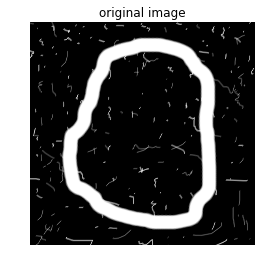

In [541]:
img_stroke = 'noisy_stroke.tif'
stroke = mpimg.imread(img_stroke)
plotGreyImage(stroke, "original image")

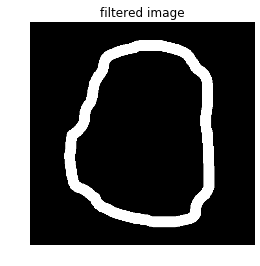

In [542]:
#add zero padding
stroke = zero_padding(stroke, 1)

#filter shape
stroke [stroke < 255] = 0
stroke [stroke == 255] = 1

plotGreyImage(stroke, "filtered image")

[ 48 278]


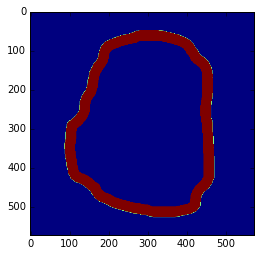

In [543]:
seq = boundary_following(test)

test = np.copy(stroke)
for element in seq:
    test[element[0],element[1]] = 0.5
    
plt.imshow(test)
plt.show()

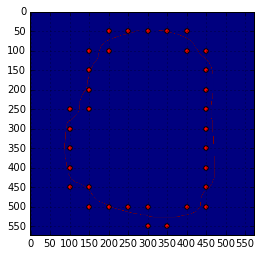

In [544]:
grid = (50,50)
resampled_seq = resampling_grid(seq, grid)

#test = np.copy(test)

x = np.matrix(resampled_seq).T[0,:]
y = np.matrix(resampled_seq).T[1,:] 

plt.scatter(x, y, c="red")

test[test == 1] = 0
plt.imshow(test)

plt.xticks(np.arange(0,test.shape[0]+1,grid[0]))
plt.yticks(np.arange(0,test.shape[1]+1,grid[1]))
plt.grid()

plt.show()

In [529]:
chain_code = calc_chain_code(resampled_seq, grid)
print chain_code

[0, 0, 0, 0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 4, 2, 4, 4, 4, 2, 4, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2]


In [538]:
first_diff = first_difference_chain_code(chain_code, is_circular=True)
print first_diff

[0, 0, 0, 6, 2, 6, 0, 0, 0, 0, 0, 0, 0, 6, 1, 7, 6, 2, 0, 0, 6, 2, 6, 0, 0, 0, 6, 2, 0, 0, 6, 2, 6]


### (b). Develop a program to implement the image description by the principal components (PC). Calculate and display the PC images and the reconstructed images from 2 PCs. Use the six images in ‘washingtonDC.rar’ as the test images.

In [57]:
def pca_fit_transform(img, pca_number):

    plotGreyImage(img, "original image")

    n = img.shape[0] / 12
    step = 12

    data = np.zeros((n*n, step*step))

    for xi in range(0, n):
        for yi in range(0, n):
            for xii in range(0,step):
                for yii in range(0,step):
                    data[xi*n + yi][xii*step + yii] = img[xi*step + xii][yi*step + yii]
    
    centered = data - data.mean(0)
    eigenvalues, eigenvectors = np.linalg.eig(np.cov(centered.T))

    #sort eigenvectors by variance
    idx = (-eigenvalues).argsort()   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    eigenvectors = np.matrix(-eigenvectors.T)
    
    product = eigenvectors * data.T

    img1 = np.zeros(img.shape)

    reconstruction = product[0:pca_number,:].T * eigenvectors[0:pca_number,:]
    
    for xi in range(0, n):
        for yi in range(0, n):
            for xii in range(0,step):
                for yii in range(0,step):
                    img1[xi*step + xii][yi*step + yii] = reconstruction[xi*n + yi,xii*step + yii]
                    
    plotGreyImage(img1, "compressed image by " + str(pca_number) + " principal components")

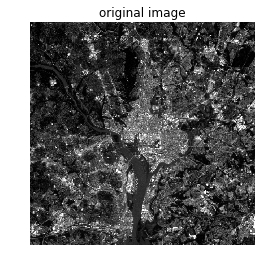

47
(2209, 144)


In [43]:
imageName = 'WashingtonDC_Band1.tif'
img = mpimg.imread(imageName)
plotGreyImage(img, "original image")


'''
n = 0
for i in range(0, 500):
    sx = randint(0,img.shape[0]-16) #random x
    sy = randint(0,img.shape[1]-16) #random y
    for xi in range(0, 16):
        for yi in range(0, 16):
            data[n][xi*16 + yi] = img[sx+xi][sy+yi]
    n = n + 1
'''

n = img.shape[0] / 12
step = 12

data = np.zeros((n*n, step*step))

print n

for xi in range(0, n):
    for yi in range(0, n):
        for xii in range(0,step):
            for yii in range(0,step):
                data[xi*n + yi][xii*step + yii] = img[xi*step + xii][yi*step + yii]

Principal components of washington:
Plot principal component number 1


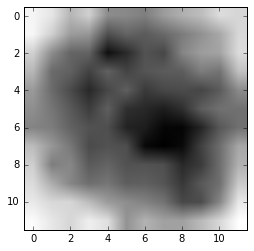

Plot principal component number 2


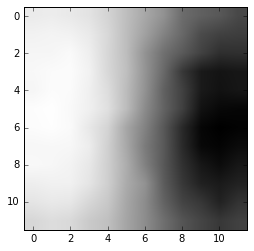

Plot principal component number 3


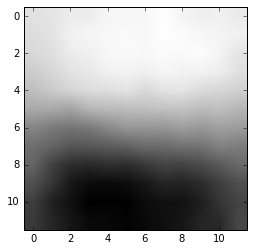

Plot principal component number 4


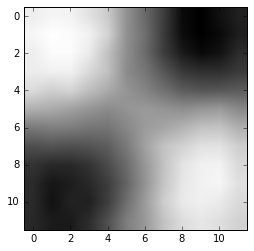

Plot principal component number 5


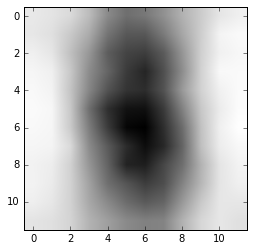

Plot principal component number 6


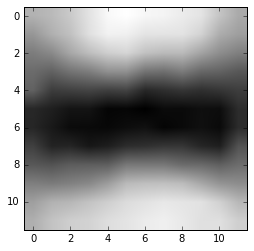

Plot principal component number 7


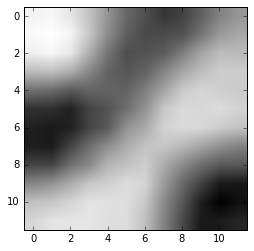

Plot principal component number 8


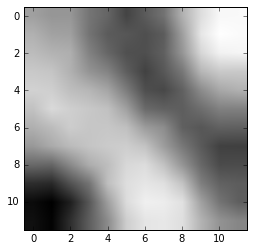

Plot principal component number 9


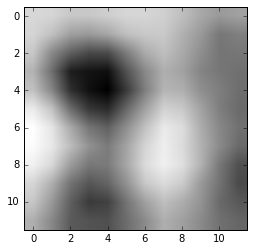

Plot principal component number 10


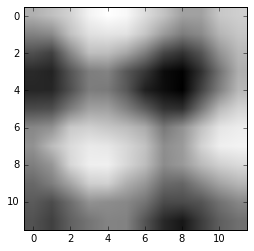

Variance / importance of principal components


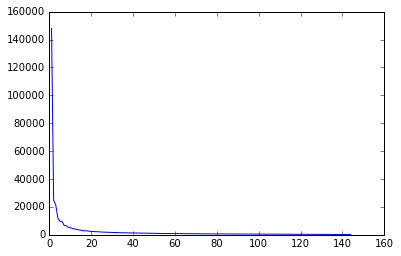

In [48]:
centered = data - data.mean(0)
eigenvalues, eigenvectors = np.linalg.eig(np.cov(centered.T))

idx = (-eigenvalues).argsort()   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]


print "Principal components of washington:"
eigenvectors = np.matrix(-eigenvectors.T)

pc = np.ones((step, step))

for o in range(0,10):
    print ("Plot principal component number " + str(o + 1))
    for xi in range(0, 12):
        for yi in range(0, 12):
            pc[xi][yi] = eigenvectors[o,xi*12 + yi]
    plt.clf()
    plt.imshow(pc, cmap='Greys_r')
    plt.show()


print ("Variance / importance of principal components")
t = np.arange(1., data.shape[1]+1 , 1)
plt.plot(t,eigenvalues)
plt.show()

Number of principal components: 1


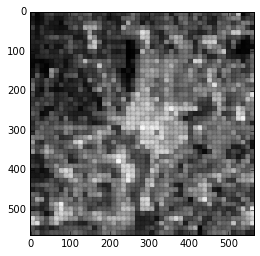

Number of principal components: 2


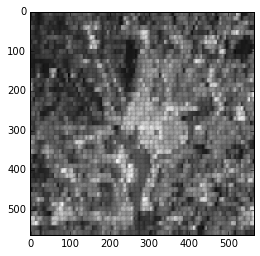

Number of principal components: 4


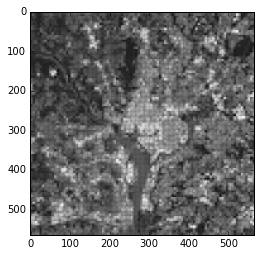

Number of principal components: 8


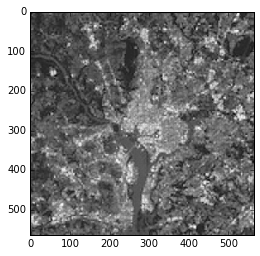

Number of principal components: 20


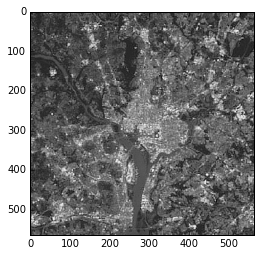

In [56]:
product = eigenvectors * data.T

img1 = np.zeros(img.shape)

for t in [1,2,4,8,20]:
    reconstruction = product[0:t,:].T * eigenvectors[0:t,:]
    
    print ("Number of principal components: " + str(t))
    
    for xi in range(0, n):
        for yi in range(0, n):
            for xii in range(0,step):
                for yii in range(0,step):
                    img1[xi*step + xii][yi*step + yii] = reconstruction[xi*n + yi,xii*step + yii]
                    
    plt.clf()
    plt.imshow(img1, cmap='Greys_r')
    plt.show()

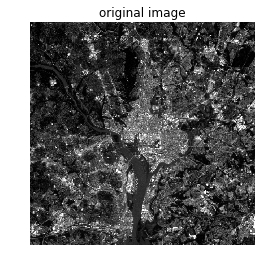

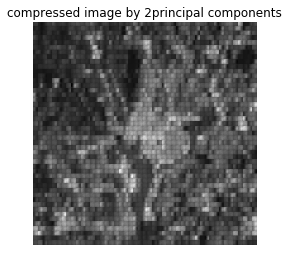

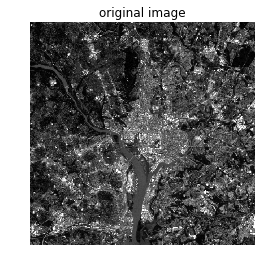

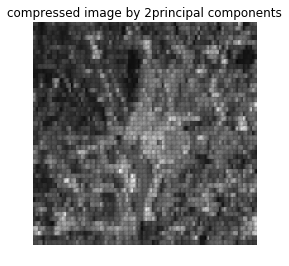

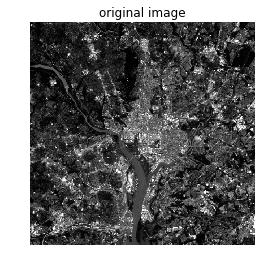

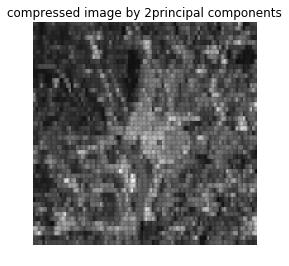

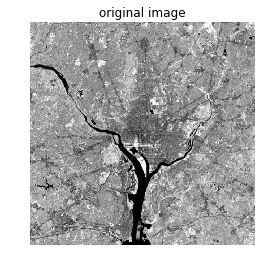

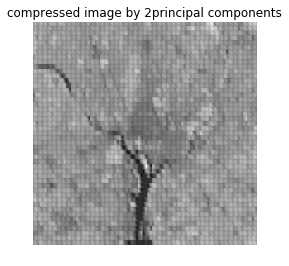

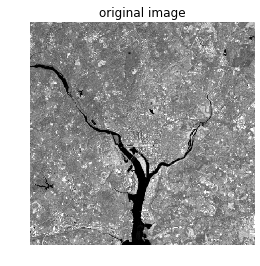

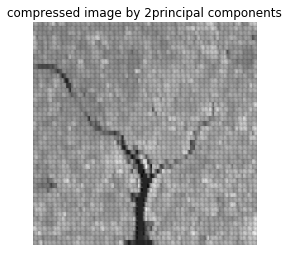

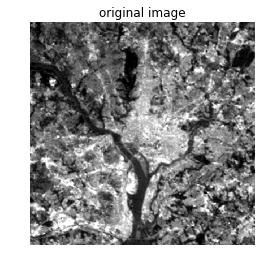

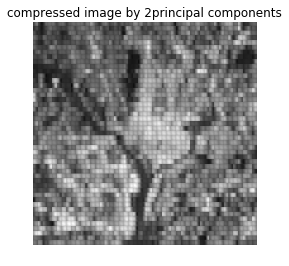

In [54]:
for i in np.arange(1,7,1):
    imageName = 'WashingtonDC_Band' + str(i) + '.tif'
    img = mpimg.imread(imageName)
    pca_fit_transform(img, 2)